In [1]:
# Import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import string
import nltk
import os
import random

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

In [7]:
# Load data
init_df = pd.read_csv('go_emotions_dataset.csv')
init_df.head(10)

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,eeibobj,Man I love reddit.,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,eespn2i,Right? Considering it’s such an important docu...,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,eczuekb,"He isn't as big, but he's still quite popular....",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,ed5tx8y,That's crazy; I went to a super [RELIGION] hig...,False,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,ef961hv,that's adorable asf,False,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,edl7cr3,"""Sponge Blurb Pubs Quaw Haha GURR ha AAa!"" fin...",False,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
init_df.example_very_unclear.value_counts()

False    207814
True       3411
Name: example_very_unclear, dtype: int64

In [9]:
# Remove unclear (in terms of emotions) comments
init_df = init_df[init_df['example_very_unclear'] == False]

In [18]:
# Reverse one-hot encoding for emotions
init_df2 = pd.DataFrame(data=init_df['text'])
init_df2['emotion'] = init_df[init_df.columns[3:]].idxmax(axis=1)
init_df2.head(10)

,text,emotion
0,That game hurt.,sadness
2,"You do right, if you don't care then fuck 'em!",neutral
3,Man I love reddit.,love
4,"[NAME] was nowhere near them, he was by the Fa...",neutral
5,Right? Considering it’s such an important docu...,gratitude
6,"He isn't as big, but he's still quite popular....",disapproval
7,That's crazy; I went to a super [RELIGION] hig...,amusement
8,that's adorable asf,amusement
9,"""Sponge Blurb Pubs Quaw Haha GURR ha AAa!"" fin...",amusement
10,"I have, and now that you mention it, I think t...",neutral


In [28]:
init_df2['emotion'].value_counts()[:15]

neutral           55298
admiration        17131
approval          15530
annoyance         11929
disapproval        8917
amusement          8862
gratitude          8437
anger              7956
curiosity          7707
disappointment     6769
confusion          6600
love               5310
caring             5147
realization        5125
joy                5120
Name: emotion, dtype: int64

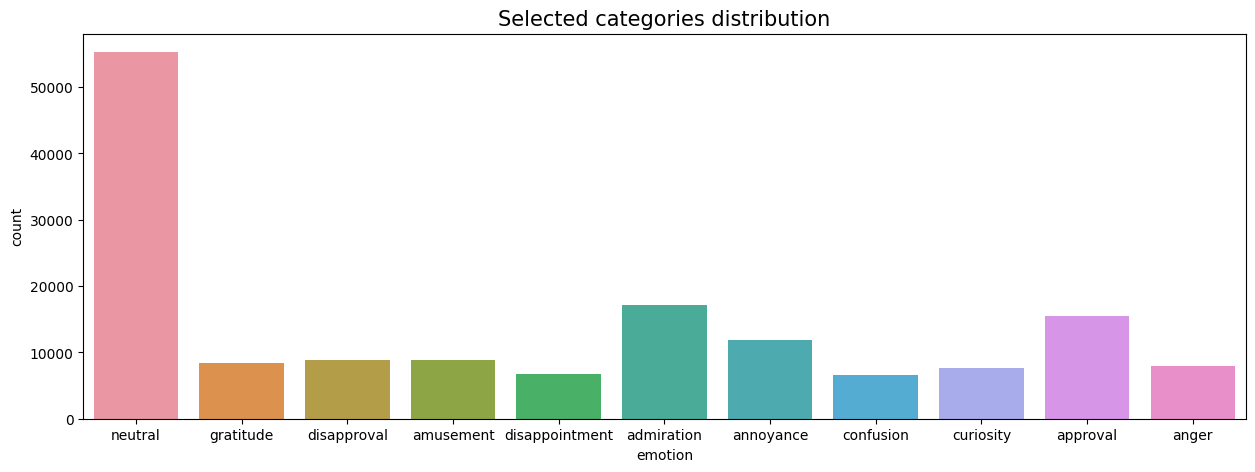

In [30]:
# Show selected categories
selected_categories = init_df2['emotion'].value_counts()[:11].index.tolist()
selected_df = init_df2[init_df2['emotion'].isin(selected_categories)]
plt.figure(figsize = [15, 5])
sns.countplot(x=selected_df["emotion"])
plt.title("Selected categories distribution", fontsize = 15)
plt.show()

In [39]:
# Downsampling the data
SEED = 1234
df_downsample = init_df2[init_df2['emotion'] == selected_df['emotion'].value_counts().sort_values().index[0]].sample(n=selected_df['emotion'].value_counts().sort_values()[0], random_state=SEED)
for i in range(len(selected_df['emotion'].unique()) - 1):
    df_downsample = pd.concat([df_downsample, init_df2[init_df2['emotion'] == selected_df['emotion'].value_counts().sort_values().index[i + 1]].sample(n=selected_df['emotion'].value_counts().sort_values()[0], random_state=SEED)])

In [40]:
df_downsample.head()

,text,emotion
151636,Definitely not a dead human body. He’s probabl...,confusion
54230,I saw these in a cart and I was so confused wh...,confusion
188116,I don’t think it’ll happen solely because of U...,confusion
124007,Maybe I’m unsure of that,confusion
36373,[NAME] and a libertarian? Is that some post-mo...,confusion


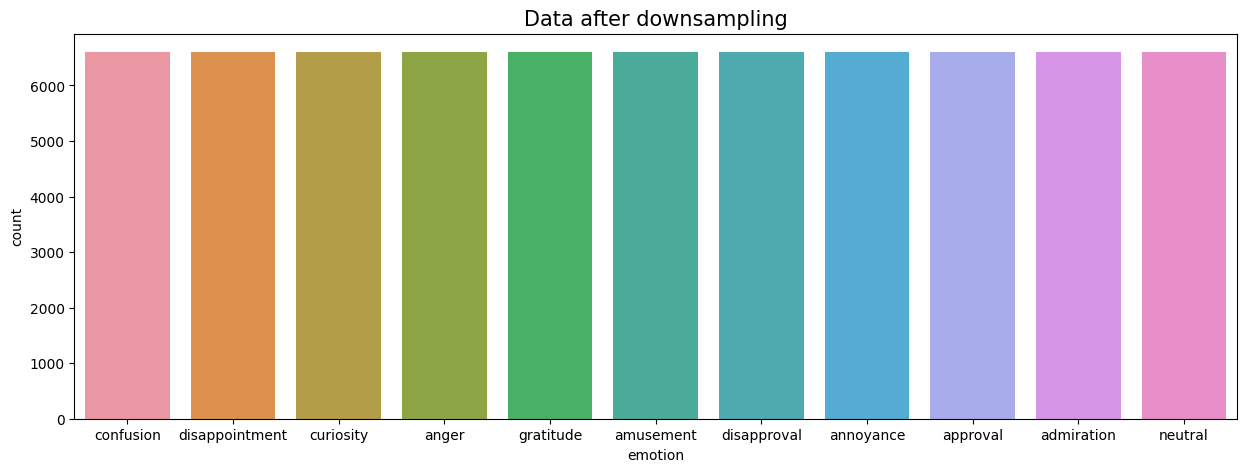

In [41]:
# Show data distribution after upsampling
plt.figure(figsize = [15, 5])
sns.countplot(x=df_downsample["emotion"])
plt.title("Data after downsampling", fontsize = 15)
plt.show()

In [42]:
# NLP preprocess stuff
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

In [43]:
# Text cleaning
df_downsample['clean_text'] = df_downsample["text"].map(lambda x: clean_text(x))
X, y = df_downsample['clean_text'], df_downsample["emotion"]

In [44]:
X.iloc[:10]

151636    definitely dead human body probably weird dude...
54230     saw cart confused tennis ball smallthen notice...
188116    think happen solely ua however surely cool happen
124007                                         maybe unsure
36373     name libertarian postmodern b like person man ...
128393                made choice yet like people like link
131820                      donut done brought ya back aint
100174         jobby new one another way saying taking crap
179412    every series prior name awful v buck name awes...
96586     maybe extremely boring bland outright refuse l...
Name: clean_text, dtype: object

In [45]:
# Train test split on the upsampled data
X_train, X_test, y_train, y_test = train_test_split(df_downsample['clean_text'], df_downsample['emotion'], test_size=0.2, stratify=df_downsample['emotion'])

# Encoding categories
le = preprocessing.LabelEncoder()
le.fit(selected_categories)
y_train_label = le.transform(y_train)
y_test_label = le.transform(y_test)

# tf-idf vectorizer
tf_idf_vectorizer = TfidfVectorizer()
X_train_t = tf_idf_vectorizer.fit_transform(X_train)
X_test_t = tf_idf_vectorizer.transform(X_test)
print(X_train.shape, X_train_t.shape)

(58080,) (58080, 22668)


In [46]:
# Dummy Classifier
dc = DummyClassifier(strategy="stratified")
dc.fit(X_train_t, y_train_label)
pred_dc = dc.predict(X_test_t)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_dc)))
print("Dummy Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_dc), average='weighted'))
print("Dummy Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_dc)))

                precision    recall  f1-score   support

    admiration       0.08      0.08      0.08      1320
     amusement       0.08      0.08      0.08      1320
         anger       0.09      0.09      0.09      1320
     annoyance       0.09      0.09      0.09      1320
      approval       0.09      0.09      0.09      1320
     confusion       0.09      0.09      0.09      1320
     curiosity       0.09      0.08      0.09      1320
disappointment       0.09      0.09      0.09      1320
   disapproval       0.09      0.09      0.09      1320
     gratitude       0.09      0.09      0.09      1320
       neutral       0.08      0.08      0.08      1320

      accuracy                           0.09     14520
     macro avg       0.09      0.09      0.09     14520
  weighted avg       0.09      0.09      0.09     14520

Dummy Classifier f1-Score: 0.08780534349921527
Dummy Classifier accuracy: 0.0878099173553719


In [47]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train_t, y_train_label)
pred_dt = dt.predict(X_test_t)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_dt)))
print("Decision Tree Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_dt), average='weighted'))
print("Decision Tree Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_dt)))

                precision    recall  f1-score   support

    admiration       0.47      0.52      0.49      1320
     amusement       0.64      0.69      0.66      1320
         anger       0.39      0.48      0.43      1320
     annoyance       0.21      0.23      0.22      1320
      approval       0.28      0.27      0.27      1320
     confusion       0.36      0.43      0.39      1320
     curiosity       0.37      0.37      0.37      1320
disappointment       0.34      0.30      0.32      1320
   disapproval       0.33      0.26      0.29      1320
     gratitude       0.72      0.69      0.71      1320
       neutral       0.23      0.17      0.19      1320

      accuracy                           0.40     14520
     macro avg       0.39      0.40      0.40     14520
  weighted avg       0.39      0.40      0.40     14520

Decision Tree Classifier f1-Score: 0.39548875032510666
Decision Tree Classifier accuracy: 0.400137741046832


In [48]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train_t, y_train_label)
pred_rf = rf.predict(X_test_t)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_rf)))
print("Random Forest Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_rf), average='weighted'))
print("Random Forest Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_rf)))

                precision    recall  f1-score   support

    admiration       0.52      0.56      0.54      1320
     amusement       0.69      0.68      0.69      1320
         anger       0.44      0.46      0.45      1320
     annoyance       0.24      0.20      0.22      1320
      approval       0.31      0.27      0.29      1320
     confusion       0.37      0.40      0.39      1320
     curiosity       0.39      0.43      0.41      1320
disappointment       0.35      0.34      0.35      1320
   disapproval       0.31      0.30      0.30      1320
     gratitude       0.71      0.75      0.73      1320
       neutral       0.23      0.22      0.22      1320

      accuracy                           0.42     14520
     macro avg       0.41      0.42      0.42     14520
  weighted avg       0.41      0.42      0.42     14520

Random Forest Classifier f1-Score: 0.41553247783855696
Random Forest Classifier accuracy: 0.41893939393939394


In [49]:
# K-Nearest Neighbors Classifier
svd = TruncatedSVD(n_components=7, random_state=SEED, n_iter=7)
X_train_t_final = svd.fit_transform(X_train_t)
X_test_t_final = svd.transform(X_test_t)

knn = KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree')
knn.fit(X_train_t_final, y_train_label)
pred_knn = knn.predict(X_test_t_final)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_knn)))
print("K-Nearest Neighbors Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_knn), average='weighted'))
print("K-Nearest Neighbors Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_knn)))

                precision    recall  f1-score   support

    admiration       0.28      0.39      0.33      1320
     amusement       0.41      0.53      0.46      1320
         anger       0.23      0.30      0.26      1320
     annoyance       0.14      0.16      0.15      1320
      approval       0.17      0.15      0.16      1320
     confusion       0.20      0.21      0.20      1320
     curiosity       0.20      0.20      0.20      1320
disappointment       0.17      0.13      0.15      1320
   disapproval       0.20      0.13      0.15      1320
     gratitude       0.75      0.73      0.74      1320
       neutral       0.12      0.07      0.09      1320

      accuracy                           0.27     14520
     macro avg       0.26      0.27      0.26     14520
  weighted avg       0.26      0.27      0.26     14520

K-Nearest Neighbors Classifier f1-Score: 0.2626537378112816
K-Nearest Neighbors Classifier accuracy: 0.2727961432506887


In [50]:
# C-Support Vector Classifier
svc = SVC()
svc.fit(X_train_t, y_train_label)
pred_svc = svc.predict(X_test_t)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_svc)))
print("C-Support Vector Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_svc), average='weighted'))
print("C-Support Vector Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_svc)))

                precision    recall  f1-score   support

    admiration       0.56      0.60      0.58      1320
     amusement       0.72      0.73      0.72      1320
         anger       0.48      0.47      0.47      1320
     annoyance       0.24      0.23      0.24      1320
      approval       0.32      0.29      0.31      1320
     confusion       0.41      0.41      0.41      1320
     curiosity       0.42      0.39      0.40      1320
disappointment       0.36      0.35      0.36      1320
   disapproval       0.32      0.31      0.31      1320
     gratitude       0.76      0.79      0.77      1320
       neutral       0.24      0.28      0.26      1320

      accuracy                           0.44     14520
     macro avg       0.44      0.44      0.44     14520
  weighted avg       0.44      0.44      0.44     14520

C-Support Vector Classifier f1-Score: 0.43870881560280844
C-Support Vector Classifier accuracy: 0.4401515151515151


In [51]:
# Multinomial Naive Bayes Classifier
mnb = MultinomialNB(alpha=1e-4, fit_prior=False)
mnb.fit(X_train_t, y_train_label)
pred_mnb = mnb.predict(X_test_t)
print(metrics.classification_report(le.inverse_transform(y_test_label), le.inverse_transform(pred_mnb)))
print("Multinomial Naive Bayes Classifier f1-Score:", metrics.f1_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_mnb), average='weighted'))
print("Multinomial Naive Bayes Classifier accuracy:", metrics.accuracy_score(le.inverse_transform(y_test_label), le.inverse_transform(pred_mnb)))

                precision    recall  f1-score   support

    admiration       0.44      0.45      0.45      1320
     amusement       0.55      0.60      0.57      1320
         anger       0.41      0.46      0.43      1320
     annoyance       0.21      0.20      0.21      1320
      approval       0.26      0.22      0.24      1320
     confusion       0.33      0.34      0.34      1320
     curiosity       0.34      0.32      0.33      1320
disappointment       0.30      0.33      0.32      1320
   disapproval       0.27      0.27      0.27      1320
     gratitude       0.62      0.72      0.67      1320
       neutral       0.19      0.14      0.16      1320

      accuracy                           0.37     14520
     macro avg       0.36      0.37      0.36     14520
  weighted avg       0.36      0.37      0.36     14520

Multinomial Naive Bayes Classifier f1-Score: 0.36208615995299553
Multinomial Naive Bayes Classifier accuracy: 0.36893939393939396


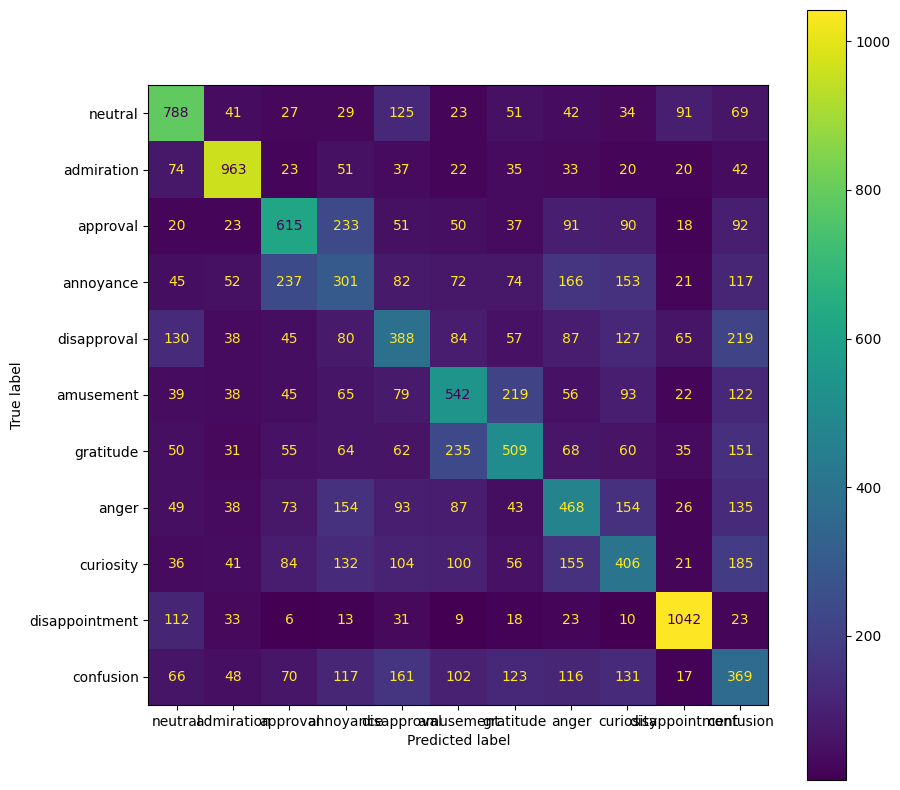

In [52]:
# Confusion Matrix for the most accurate model (C-Support Vector Classifier)
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix_svc = metrics.confusion_matrix(y_test_label.tolist(), pred_svc.tolist())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_svc, display_labels = selected_categories)
cm_display.plot(ax=ax)
plt.show()

In [53]:
# LSTM model
# Max of the length for padding
maxlen = 200

# Tokenize
oov_token = "<oov_token>"
tokenizer = Tokenizer(oov_token = oov_token)
tokenizer.fit_on_texts(df_downsample.text.to_list()) 

# The word_index dictionary assigns a unique index to each unique word
word_index = {}
word_index = tokenizer.word_index
vocabulary = len(word_index) +1
print('Vocabulary : {}'.format(vocabulary))

# Convert into padded sequences                                               
X_tokenizer = tokenizer.texts_to_sequences(df_downsample.text.to_list())
X_padded = pad_sequences(X_tokenizer, maxlen=maxlen, truncating='post',padding='pre')
print('Shape of data tensor:', X_padded.shape)

# One-hot encoding for classes
Y = pd.get_dummies(df_downsample['emotion'].values)
print('Shape of label tensor:', Y.shape)

# Split data
X_train_padded, X_test_padded, Y_train_dummy, Y_test_dummy = train_test_split(X_padded, Y, test_size=0.2, random_state=SEED)
print(X_train_padded.shape,Y_train_dummy.shape)
print(X_test_padded.shape,Y_test_dummy.shape)
Y.head()

Vocabulary : 27222
Shape of data tensor: (72600, 200)
Shape of label tensor: (72600, 11)
(58080, 200) (58080, 11)
(14520, 200) (14520, 11)


,admiration,amusement,anger,annoyance,approval,confusion,curiosity,disappointment,disapproval,gratitude,neutral
0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0


In [54]:
X_tokenizer[0]

[272,
 16,
 5,
 553,
 666,
 682,
 329,
 182,
 20,
 5,
 258,
 214,
 9,
 78,
 80,
 258,
 116,
 15,
 76,
 701,
 9,
 3236,
 377]

In [55]:
X_train_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [56]:
# Load glove
glove_dictionary = {}
with open('./glove6b/glove.6B.200d.txt',encoding="utf8") as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [57]:
# Initiating empty vectors for new words (which are missing in glove)
embedding_matrix = np.zeros((vocabulary, maxlen))

# The glove_dictionary contains words vs their respective embeddings. Create the embedding matrix using the glove_dictionary
for word, i in word_index.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [58]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [60]:
def build_model(embed_weights):
  
    embedding_output_dims = 200
    model = tf.keras.Sequential()
    
    model.add(Embedding(vocabulary, embedding_output_dims, weights=[embed_weights], input_length=maxlen))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.2))
    # Final layer : add output layer and activation 
    model.add(Dense(11, activation='sigmoid'))

    # Use a loss function, optimizer as adam to compile 
    # and evaluate model on auc,precision,recall,accuracy
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['AUC', 'Recall', 'Precision', 'accuracy'])
    
    print(model.summary)
    return model

In [63]:
epochs = 100

model = build_model(embedding_matrix)

# train and validate the model on the padded sequences of text which we have created initially       
history = model.fit(X_train_padded, 
                    Y_train_dummy, 
                    epochs=epochs, 
                    verbose=1,
                    batch_size=64,
                    validation_split=0.1,
                    validation_data=(X_test_padded, Y_test_dummy))

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000001686DD42D40>>
Epoch 1/100
908/908 [==============================] - 27s 28ms/step - loss: 2.3969 - auc: 0.5251 - recall: 0.7059 - precision: 0.0945 - accuracy: 0.1057 - val_loss: 2.3764 - val_auc: 0.5734 - val_recall: 0.8076 - val_precision: 0.0982 - val_accuracy: 0.1416
Epoch 2/100
908/908 [==============================] - 25s 28ms/step - loss: 2.3689 - auc: 0.5708 - recall: 0.7517 - precision: 0.1003 - accuracy: 0.1408 - val_loss: 2.3460 - val_auc: 0.6172 - val_recall: 0.8304 - val_precision: 0.1038 - val_accuracy: 0.1759
Epoch 3/100
908/908 [==============================] - 25s 28ms/step - loss: 2.3326 - auc: 0.6054 - recall: 0.7819 - precision: 0.1055 - accuracy: 0.1696 - val_loss: 2.2958 - val_auc: 0.6459 - val_recall: 0.8508 - val_precision: 0.1080 - val_accuracy: 0.1988
Epoch 4/100
908/908 [==============================] - 25s 28ms/step - loss: 2.2738 - auc: 0.6343 - recall: 0.8108 - precisio

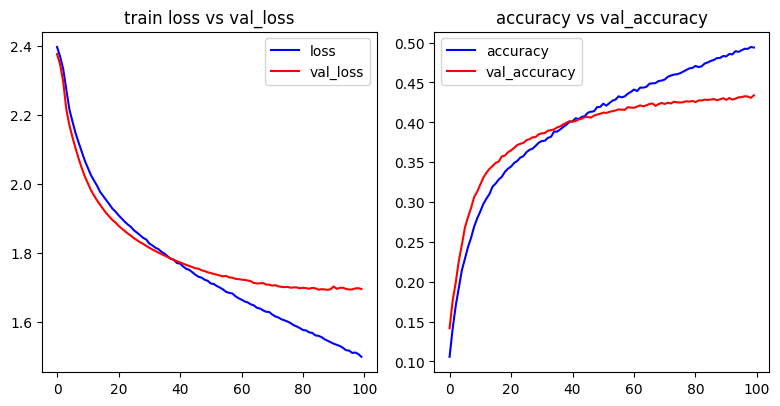

In [64]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
fig.tight_layout()

axs[0].plot(history.history['loss'], 'b', label = 'loss')
axs[0].plot(history.history['val_loss'], 'r', label = 'val_loss')
axs[0].set_title("train loss vs val_loss")
axs[0].legend()

axs[1].plot(history.history['accuracy'], 'b', label = 'accuracy')
axs[1].plot(history.history['val_accuracy'], 'r', label = 'val_accuracy')
axs[1].set_title("accuracy vs val_accuracy")
axs[1].legend()

plt.show()

In [65]:
model.save('emotion_classification')

INFO:tensorflow:Assets written to: emotion_classification\assets


INFO:tensorflow:Assets written to: emotion_classification\assets


In [66]:
def predict_category(text):
    # Tokenize and pad
    tokenized_text = tokenizer.texts_to_sequences([text])
    tokenized_text_padded = pad_sequences(tokenized_text, maxlen=maxlen, truncating='post', padding='pre')

    #The higherst probability score will be saved as prediction category
    prediction = model.predict(tokenized_text_padded, verbose=0)[0].tolist()
    index = prediction.index(max(prediction))
    categories = Y.columns.to_list()
    pred_category = categories[index]
    return pred_category

In [70]:
# Test on 5 random rows
random_sample = random.sample(range(0, X.shape[0]), 5)
for i in random_sample:
    print(df_downsample['text'].iloc[i], '\n::: TRUE - PREDICT :::', df_downsample['emotion'].iloc[i], '-', predict_category(X.iloc[i]), ':::\n')

why thank you! 
::: TRUE - PREDICT ::: gratitude - gratitude :::

What's the fucking point of this post? Is just baseless claims with no proof to back them up. 
::: TRUE - PREDICT ::: anger - anger :::

Hahah, it's all good now since I've got a mouse now 
::: TRUE - PREDICT ::: amusement - admiration :::

And you know they never grow out of that...I hate people. Myself included. 
::: TRUE - PREDICT ::: anger - anger :::

I'm seeing this everywhere, what does BEC mean? 
::: TRUE - PREDICT ::: curiosity - neutral :::



In [73]:
# Load our data
df_reddit = pd.read_json('data.json', lines=True)[['comment_1', 'comment_2', 'comment_3',]]

In [74]:
df_reddit

,comment_1,comment_2,comment_3
0,Not only did Robinhood move the goalposts when...,a class action lawsuit has been filed. further...,"Basically, Robinhood just stated that your acc..."
1,Please please PLEASE let this happen. The wor...,"In US trademark law it's first to use, not fir...","It sounds silly, but some years ago the UK pol..."
2,The penalty for attempted suicide is death,Daily beatings will continue until morale impr...,"From what I understood, they said anyone that ..."
3,"Hey guys - while you’re at it, please shut it ...",750 million people in Europe. Even Zucky won't...,As much as I agree with politicians who say li...
4,"I'll take ""Shit I never thought would be a hea...",Tide Pod Challenge - White House Edition,I just got a letter from my georgia congressma...
...,...,...,...
9897,What criteria does the bot use to determine wh...,"Somewhat off-topic, but if you find this inter...",If the Taliban realise western civilisation is...
9898,I don't know if these companies actually have ...,This appears to be using a short-term view to ...,"FTA: ""There has been merger after merger,"" Jo..."
9899,This seems like a pretty minor indictment even...,Looks like the legal documents are included in...,__I'm a bot. Here are The Factual credibility ...
9900,"Mods, please let me know if I need to include ...",The [Guardian article](https://www.theguardian...,Interesting. I am unsure as to the science beh...


In [81]:
# Preprocess and predict
df_reddit['cleaned_comment_1'] = df_reddit['comment_1'].map(lambda x: clean_text(x))
df_reddit['cleaned_comment_2'] = df_reddit['comment_2'].map(lambda x: clean_text(x))
df_reddit['cleaned_comment_3'] = df_reddit['comment_3'].map(lambda x: clean_text(x))
df_reddit['pred_emotion_1'] = df_reddit['cleaned_comment_1'].map(lambda x: predict_category(x))
df_reddit['pred_emotion_2'] = df_reddit['cleaned_comment_2'].map(lambda x: predict_category(x))
df_reddit['pred_emotion_3'] = df_reddit['cleaned_comment_3'].map(lambda x: predict_category(x))

In [82]:
df_reddit.head(10)

,comment_1,comment_2,comment_3,cleaned_comment_1,cleaned_comment_2,cleaned_comment_3,pred_emotion_1,pred_emotion_2,pred_emotion_3
0,Not only did Robinhood move the goalposts when...,a class action lawsuit has been filed. further...,"Basically, Robinhood just stated that your acc...",robinhood move goalpost like score prevented t...,class action lawsuit filed government supposed...,basically robinhood stated account real benefi...,disappointment,anger,approval
1,Please please PLEASE let this happen. The wor...,"In US trademark law it's first to use, not fir...","It sounds silly, but some years ago the UK pol...",please please please let happen world insane w...,u trademark law first use first file long u go...,sound silly year ago uk police tried challenge...,amusement,amusement,disapproval
2,The penalty for attempted suicide is death,Daily beatings will continue until morale impr...,"From what I understood, they said anyone that ...",penalty attempted suicide death,daily beating continue morale improves,understood said anyone look employment elsewhe...,anger,anger,confusion
3,"Hey guys - while you’re at it, please shut it ...",750 million people in Europe. Even Zucky won't...,As much as I agree with politicians who say li...,hey guy please shut u could use nice mental re...,750 million people europe even zucky wont give...,much agree politician say life would good with...,anger,neutral,anger
4,"I'll take ""Shit I never thought would be a hea...",Tide Pod Challenge - White House Edition,I just got a letter from my georgia congressma...,ill take shit never thought would headline 800,tide pod challenge white house edition,got letter georgia congressman saying need hol...,anger,neutral,anger
5,That means he wasn't lost enough.,"Ahh, the unforeseen consequences of telemarket...",Did they leave a message or text him?,mean wasnt lost enough,ahh unforeseen consequence telemarketing robot...,leave message text,disappointment,anger,disapproval
6,I'm reminded of that parks & rec scene during ...,"Meanwhile, our school board just froze our pay...",Parent: We should increase pay for teachers. ...,im reminded park rec scene shutdown woman asks...,meanwhile school board froze pay next budget c...,parent increase pay teacher government ok rais...,anger,neutral,disapproval
7,Apparently this doctor has a PhD in throwing s...,"Imagine if the ref had thrown the flag, but th...",Does A or B look more like pass interference? ...,apparently doctor phd throwing shade well opto...,imagine ref thrown flag picked back happened l...,b look like pas interference b x200b edit than...,neutral,disappointment,gratitude
8,This feels like a notification I'd get while p...,"Well, well, well. How the turntables...",I think the irony is here very strongly. I su...,feel like notification id get playing civ,well well well turntable,think irony strongly suppose chile weighed com...,disapproval,admiration,confusion
9,I love the ever present pop up in seamless for...,What the hell happened here?,and here it is at the top of reddit for free.,love ever present pop seamless subscription se...,hell happened,top reddit free,gratitude,anger,neutral


In [83]:
df_reddit.pred_emotion_1.value_counts()

anger             1727
neutral           1366
approval          1166
admiration        1056
disapproval       1006
curiosity          831
disappointment     717
annoyance          648
confusion          569
amusement          442
gratitude          374
Name: pred_emotion_1, dtype: int64

In [84]:
df_reddit.pred_emotion_2.value_counts()

anger             1784
neutral           1344
approval          1120
admiration        1089
disapproval        904
curiosity          858
disappointment     747
annoyance          620
confusion          555
amusement          498
gratitude          383
Name: pred_emotion_2, dtype: int64

In [85]:
df_reddit.pred_emotion_3.value_counts()

anger             1783
neutral           1410
approval          1101
admiration         999
disapproval        889
curiosity          821
disappointment     728
annoyance          663
confusion          582
gratitude          479
amusement          447
Name: pred_emotion_3, dtype: int64

In [87]:
df_reddit[['comment_1', 'comment_2', 'comment_3', 'pred_emotion_1', 'pred_emotion_2', 'pred_emotion_3']].to_csv('pred_emotions.csv', index=False)